<h1 align=center><font size = 5>Capstone Project - The Battle of Neighborhoods (Week 2)</font></h1> 

<h2 align=center><font size = 4> By Awet Tsegai</font></h1>

<h2 align=center><font size = 4>Using machine learning to find location for opening a new restaurant in Michigan.</font></h1> 

## I. IMPORTING AND EXPLORING THE DATA

#### Import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


In [34]:
#Import library  (unmark if not already installed)
#import geocoder  to get coordinates
#!pip install geopy #unmark if not already installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!pip install geocoder #unmark if not already installed
import geocoder

#map rendering library
#!pip install folium #unmark if not already installed
import folium

#lxml html reader
#! pip3 install lxml # run if not aleady installed
print('Libraries imported.')

Libraries imported.


#### Download and explore the data

In [3]:
df=pd.read_html('https://en.wikipedia.org/wiki/List_of_Michigan_locations_by_per_capita_income')
df = df[1]
print(df.shape)
df.head()

(85, 7)


,Rank,County,Per capitaincome,Medianhouseholdincome,Medianfamilyincome,Population,Number ofhouseholds
0,1.0,Oakland,"$56,138","$85,991","$94,783",1202362,483698
1,2.0,Leelanau,"$32,194","$56,527","$65,342",21708,9255
2,3.0,Livingston,"$31,609","$72,129","$82,637",180967,67380
3,4.0,Washtenaw,"$31,316","$59,065","$82,184",344791,137193
4,5.0,Charlevoix,"$28,403","$48,704","$57,022",25949,10882


#### Clean and select Data

Data will be cleaned to remove NaN from rank and dollar symboles from income and str will be converted to int for income.

In [4]:
df.dropna(axis=0, inplace=True)
df.drop(['Rank', 'Medianhouseholdincome', 'Medianfamilyincome','Number ofhouseholds'], axis=1 , inplace=True)
df.rename(columns= {'County':'Neighborhood', 'Per capitaincome':'Income'}, inplace=True)
df.Income = [x.strip('$') for x in df.Income]
df.Income = df.Income.str.replace(',', '')
df["Income"] = df["Income"].astype(str).astype(int)
print(df.shape)
df.head()

(83, 3)


,Neighborhood,Income,Population
0,Oakland,56138,1202362
1,Leelanau,32194,21708
2,Livingston,31609,180967
3,Washtenaw,31316,344791
4,Charlevoix,28403,25949


In [5]:
# Describing the data
df.describe()

,Income,Population
count,83.000000,8.300000e+01
mean,22439.626506,1.190800e+05
std,4972.042135,2.597951e+05
min,16084.000000,2.156000e+03
25%,19814.000000,2.261800e+04
50%,21624.000000,3.852000e+04
75%,23841.000000,9.410550e+04
max,56138.000000,1.820584e+06


#### Remove Outliers 

Population below 10,000 (fewer customers) and above 600000 (high competitive) will be removed

In [6]:
df_mi=df[df.Population.gt(10000) & df.Population.lt(600000)]
print(df_mi.shape)
df_mi.head()

(71, 3)


,Neighborhood,Income,Population
1,Leelanau,32194,21708
2,Livingston,31609,180967
3,Washtenaw,31316,344791
4,Charlevoix,28403,25949
5,Midland,28363,83629


#### Download coordinates

Longitude and latitude of each neighborhood will be downlaoded

In [7]:
# define a function to get coordinates
def get_latlng(Neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{} , MI, USA'.format(Neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [8]:
# call the function to get the coordinates, store in a new list using list comprehension
df_coords = [ get_latlng(Neighborhood) for Neighborhood in df["Neighborhood"].tolist() ]
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(df_coords, columns=['Latitude', 'Longitude'])
print(df_coords.shape)
df_coords.head()

(83, 2)


,Latitude,Longitude
0,42.742140,-83.161740
1,44.938491,-85.811823
2,41.968310,-86.542530
3,42.253229,-83.838777
4,45.316530,-85.260720


#### Merge Coordinates to the main data 

In [9]:
df_mi=df_mi.merge(df_coords, left_index=True , right_index=True)
#df_mi.drop(['Longitude_x', 'Latitude_x'], axis=1, inplace=True)
#df_clusters.rename(columns={'Longitude_y':'Longitude', 'Latitude_y':'Latitude'},inplace=True)
print(df_mi.shape)
df_mi.head()

(70, 5)


,Neighborhood,Income,Population,Latitude,Longitude
1,Leelanau,32194,21708,44.938491,-85.811823
2,Livingston,31609,180967,41.968310,-86.542530
3,Washtenaw,31316,344791,42.253229,-83.838777
4,Charlevoix,28403,25949,45.316530,-85.260720
5,Midland,28363,83629,43.617080,-84.245060


#### Download venues from Foursquare

In [10]:
#Foursquare API credentials 
CLIENT_ID = 'JD0MT5LNGHEA5UL1ZZCGXKBKDQ0IFHGWEOAXEU0U1W0Y0ICO' 
CLIENT_SECRET = 'NTQIGETPKBWWRTEIQ5N0P415S4QZ2BTLG3LR4MKP252WKYBK' 
VERSION = '20180605' 

#Michigan venues to explor
LIMIT =100
radius =2500

def getNearbyVenues(name, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(name, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
michigan_venues = getNearbyVenues(name=df_mi['Neighborhood'],
                                   latitudes=df_mi['Latitude'],
                                   longitudes=df_mi['Longitude']
                                  )
print(michigan_venues.shape)
michigan_venues.head()

(1528, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Leelanau,44.938491,-85.811823,Good Harbor Bay Beach,44.947617,-85.811430,Beach
1,Leelanau,44.938491,-85.811823,Good Harbor Trail,44.929190,-85.834993,Trail
2,Leelanau,44.938491,-85.811823,Swanson Preserve,44.920907,-85.824049,Trail
3,Leelanau,44.938491,-85.811823,Cleveland Township Park,44.928629,-85.839381,Park
4,Livingston,41.968310,-86.542530,D'Agostino's Navajo Bar & Grille,41.956402,-86.552969,Italian Restaurant


## II. DATA ANALYSIS

#### Count number of venues in Neighborhood 

Here only venues that will affact influence opening restaurants will be counted, these are other restaurants, bars, theaters , cafe, shopes, pizza. 

In [12]:
michigan_restaurant = michigan_venues[(michigan_venues['Venue Category'].str.contains('Restaurant', regex=False)) | (michigan_venues['Venue Category'].str.contains('Shop', regex=False)) |(michigan_venues['Venue Category'].str.contains('Pizza', regex=False)) |  (michigan_venues['Venue Category'].str.contains('bar', regex=False)) | (michigan_venues['Venue Category'].str.contains('cafe', regex=False)) | (michigan_venues['Venue Category'].str.contains('theater', regex=False)) | (michigan_venues['Venue Category'].str.contains('Bar', regex=False))].groupby(['Neighborhood']).count()

michigan_restaurant.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
michigan_restaurant.rename(columns = {'Venue Category':'Number of restaurants'}, inplace=True)
michigan_restaurant.shape


,Number of restaurants
Neighborhood,
Alcona,8
Allegan,16
Alpena,17
Barry,4
Bay,5


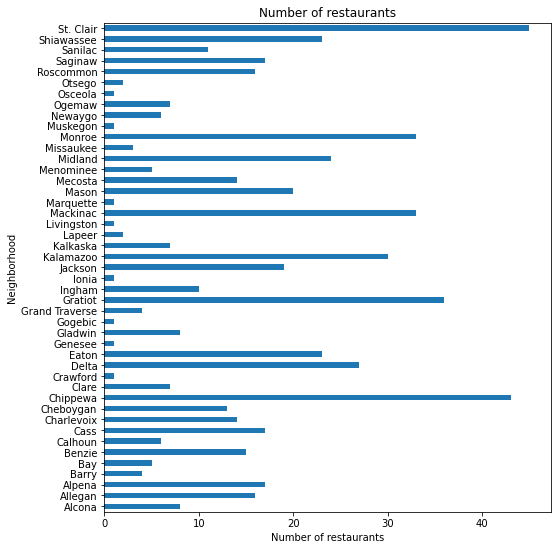

In [18]:
# Number of restaurants
michigan_restaurant[['Number of restaurants',]].plot(kind='barh', figsize=(8,9 ), legend = None)

plt.xlabel('Number of restaurants') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.title('Number of restaurants') # add title to the plot
plt.show()

In [20]:
# join above dataframe to the main df
df_mi = df_mi.join(michigan_restaurant, on='Neighborhood')
df_mi.dropna(axis=0, inplace=True)
#df_mi.fillna(0, inplace=True)
#df_clusters =df_clusters[df_clusters.Population.gt(30000) & df_clusters.Population.lt(700000) ]
print(df_mi.shape)
df_mi.head()

(45, 6)


,Neighborhood,Income,Population,Latitude,Longitude,Number of restaurants
2,Livingston,31609,180967,41.96831,-86.54253,1.0
4,Charlevoix,28403,25949,45.31653,-85.26072,14.0
5,Midland,28363,83629,43.61708,-84.24506,24.0
9,Grand Traverse,27091,86986,42.69565,-82.92171,4.0
11,Eaton,25963,107759,41.91606,-83.39790,23.0


In [21]:
df_clusters=df_mi[['Income', 'Population', 'Number of restaurants']].copy()
print(df_clusters.shape)
df_clusters.head()

(45, 3)


,Income,Population,Number of restaurants
2,31609,180967,1.0
4,28403,25949,14.0
5,28363,83629,24.0
9,27091,86986,4.0
11,25963,107759,23.0


#### Data clustering

Data will be standerized and with Elbow method K will selected

In [22]:
# Data standerize 
from sklearn.preprocessing import StandardScaler
df_clusters = StandardScaler().fit_transform(df_clusters)
df_clusters[0:3]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 3.20619129,  1.18325904, -1.04147743],
       [ 2.10491178, -0.65782114,  0.06026633],
       [ 2.09117155,  0.02721869,  0.90776152]])

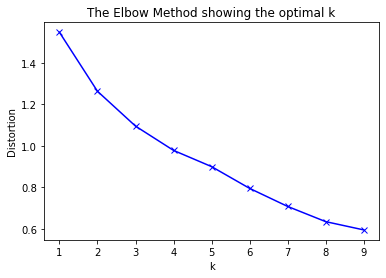

In [23]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_clusters)
    kmeanModel.fit(df_clusters)
    distortions.append(sum(np.min(cdist(df_clusters, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_clusters.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Data will be clustered with k = 4

In [24]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 3, 2, 0, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 3,
       2, 3, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1], dtype=int32)

In [25]:
# Merge cluster to the main dataframe

df_mi.insert(0, 'Cluster Labels', kmeans.labels_)
df_mi.head()

,Cluster Labels,Neighborhood,Income,Population,Latitude,Longitude,Number of restaurants
2,0,Livingston,31609,180967,41.96831,-86.54253,1.0
4,0,Charlevoix,28403,25949,45.31653,-85.26072,14.0
5,0,Midland,28363,83629,43.61708,-84.24506,24.0
9,0,Grand Traverse,27091,86986,42.69565,-82.92171,4.0
11,0,Eaton,25963,107759,41.91606,-83.39790,23.0


## III. RESULTS

#### Create a map of Michigan with neighborhoods superimposed on top.

Four clusters represented with color code

In [33]:
# create map
map_clusters = folium.Map(location=[43.6211955, -84.6824346], zoom_start=6)
colours = ['red', 'black', 'blue', 'violet']
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, income,popu, restu in zip(df_mi['Latitude'], df_mi['Longitude'], df_mi['Neighborhood'], df_mi['Cluster Labels'], df_clusters[:,0],df_clusters[:,1],df_clusters[:,2]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        color=colours[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=colours[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Scattered plot of clusters with luster center

Scatter plots of the normalized data (number of resturants vs income) and clusters defined with colors as well as size (size in increasing order from cluster 0 to cluster 3). The black star marker is representing the centroid of each cluster.

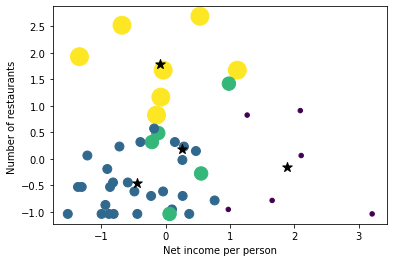

In [27]:
import matplotlib.pyplot as plt
y_kmeans = kmeans.predict(df_clusters)
clusterL = df_mi['Cluster Labels']
plt.scatter(df_clusters[:, 0], df_clusters[:, 2], c=y_kmeans, s=(clusterL+1)*20*(clusterL+1), cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='black', s=100, marker= '*');
plt.xlabel('Net income per person')
plt.ylabel('Number of restaurants ')
plt.show()

#### Population size in each cluster

(6, 7)


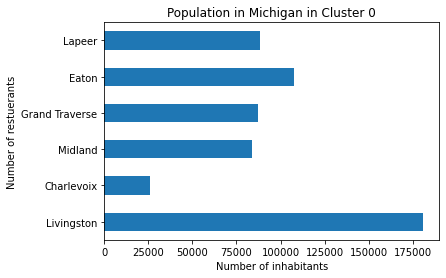

In [28]:
# Cluster 0 plot data
df_c0=df_mi[(df_mi['Cluster Labels'] == 0)]
print(df_c0.shape)
df_c0[['Neighborhood', 'Population']].plot(kind='barh', legend = None)

plt.xlabel('Number of inhabitants') # add to x-label to the plot
plt.ylabel('Number of restuerants') # add y-label to the plot
plt.title('Population in Michigan in Cluster 0') # add title to the plot
plt.yticks (np.arange(6), df_c0['Neighborhood'])
plt.show()

(27, 7)


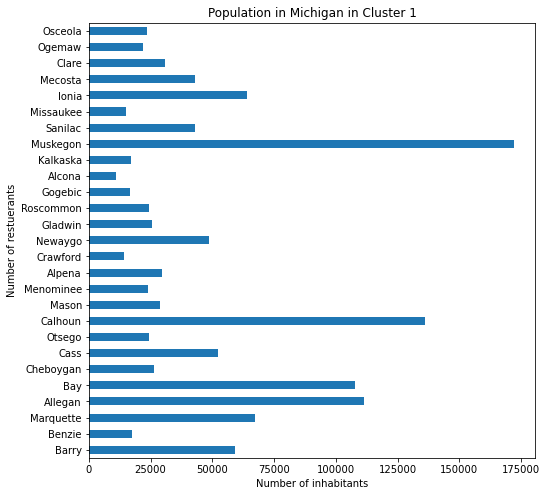

In [29]:
# Cluster 1 plot data
df_c1=df_mi[(df_mi['Cluster Labels'] == 1)]
print(df_c1.shape)
df_c1[['Neighborhood', 'Population']].plot(kind='barh', figsize=(8,8 ), legend = None)

plt.xlabel('Number of inhabitants') # add to x-label to the plot
plt.ylabel('Number of restuerants') # add y-label to the plot
plt.title('Population in Michigan in Cluster 1') # add title to the plot
plt.yticks(np.arange(27), df_c1['Neighborhood'])
plt.show()

(5, 7)


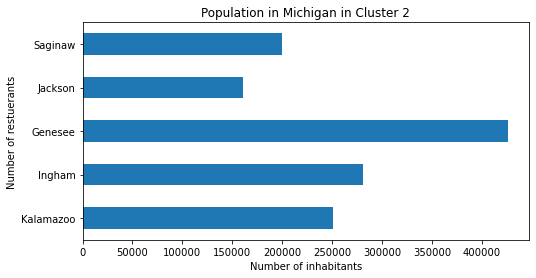

In [30]:
# Cluster 2 plot data
df_c2=df_mi[(df_mi['Cluster Labels'] == 2)]
print(df_c2.shape)
df_c2[['Neighborhood', 'Population']].plot(kind='barh', figsize=(8,4),legend = None)

plt.xlabel('Number of inhabitants') # add to x-label to the plot
plt.ylabel('Number of restuerants') # add y-label to the plot
plt.title('Population in Michigan in Cluster 2') # add title to the plot
plt.yticks (np.arange(5), df_c2['Neighborhood'])
plt.show()

(7, 7)


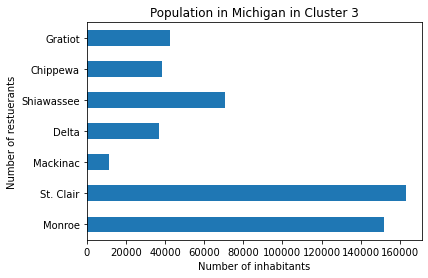

In [31]:
# Cluster 3 plot data
df_c3=df_mi[(df_mi['Cluster Labels'] == 3)]
print(df_c3.shape)
df_c3[['Neighborhood', 'Population']].plot(kind='barh', legend = None)

plt.xlabel('Number of inhabitants') # add to x-label to the plot
plt.ylabel('Number of restuerants') # add y-label to the plot
plt.title('Population in Michigan in Cluster 3') # add title to the plot
plt.yticks (np.arange(7), df_c3['Neighborhood'])
plt.show()

#### See Report for Discussion and Conclusion